<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_2_lif_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - The Leaky Integrate and Fire Neuron
## Tutorial 2
### By Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_2_lif_neuron.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>


# Introduction
In this tutorial, you will:
* Learn the fundamentals of the leaky integrate-and-fire (LIF) neuron model
* Use snnTorch to implement a first order LIF neuron

Install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

%pip install snntorch

In [3]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [4]:
#@title Plotting Settings
def plot_mem(mem, title=False):
  if title:
    plt.title(title)
  plt.plot(mem)
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, 50])
  plt.ylim([0, 1])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_out, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential 
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

  plt.show()

# 1. The Spectrum of Neuron Models
A large variety of neuron models are out there, ranging from biophysically accurate models (i.e., the Hodgkin-Huxley models) to the extremely simple artificial neuron that pervades all facets of modern deep learning.

**Hodgkin-Huxley Neuron Models**$-$While biophysical models can reproduce electrophysiological results with a high degree of accuracy, their complexity makes them difficult to use at present.

**Artificial Neuron Model**$-$On the other end of the spectrum is the artificial neuron. The inputs are multiplied by their corresponding weights and passed through an activation function. This simplification has enabled deep learning researchers to perform incredible feats in computer vision, natural language processing, and many other machine learning-domain tasks.

**Leaky Integrate-and-Fire Neuron Models**$-$Somewhere in the middle of the divide lies the leaky integrate-and-fire (LIF) neuron model. It takes the sum of weighted inputs, much like the artificial neuron. But rather than passing it directly to an activation function, it will integrate the input over time with a leakage, much like an RC circuit. If the integrated value exceeds a threshold, then the LIF neuron will emit a voltage spike. The LIF neuron abstracts away the shape and profile of the output spike; it is simply treated as a discrete event. <font color="red">As a result, information is not stored within the spike, but rather the timing (or frequency) of spikes. </font>Simple spiking neuron models have produced much insight into the neural code, memory, network dynamics, and more recently, deep learning. The LIF neuron sits in the sweet spot between biological plausibility and practicality. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center>


The different versions of the LIF model each have their own dynamics and use-cases. snnTorch currently supports the following LIF neurons:
* Lapicque's RC model: ``snntorch.Lapicque``
* 1st-order model: ``snntorch.Leaky`` 
* Synaptic Conductance-based neuron model: ``snntorch.Synaptic``
* Recurrent 1st-order model: ``snntorch.RLeaky``
* Recurrent Synaptic Conductance-based neuron model: ``snntorch.RSynaptic``
* Alpha neuron Model: ``snntorch.Alpha``

Several other non-LIF spiking neurons are also available. This tutorial focuses on the first of these models. This will be used to build towards the other models in [subsequent tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).

<font color="orange">Notes : LIF神经元模型的leak体现在哪里?</font>

LIF（Leaky Integrate-and-Fire）神经元模型中的“leak”指的是膜电位随时间的衰减。具体来说，LIF模型模拟了神经元膜电位的变化过程，其中电位会随着时间逐渐回到基线值，这个过程类似于电容器的放电

# 2. The Leaky Integrate-and-Fire Neuron Model

## 2.1 Spiking Neurons: Intuition

In our brains, a neuron might be connected to 1,000 $-$ 10,000 other neurons. If one neuron spikes, all downhill neurons might feel it. But what determines whether a neuron spikes in the first place? The past century of experiments demonstrate that if a neuron experiences *sufficient* stimulus at its input, then it might become excited and fire its own spike. 

Where does this stimulus come from? It could be from:
* the sensory periphery, 
* an invasive electrode artificially stimulating the neuron, or in most cases,
* from other pre-synaptic neurons. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true' width="500">
</center>

Given that these spikes are very short bursts of electrical activity, it is quite unlikely for all input spikes to arrive at the neuron body in precise unison. This indicates the presence of temporal dynamics that 'sustain' the input spikes, kind of like a delay.



## 2.2 The Passive Membrane

Like all cells, a neuron is surrounded by a thin membrane. This membrane is a lipid bilayer that insulates the conductive saline solution within the neuron from the extracellular medium. Electrically, the two conductive solutions separated by an insulator act as a capacitor. 

Another function of this membrane is to control what goes in and out of this cell (e.g., ions such as Na$^+$). The membrane is usually impermeable to ions which blocks them from entering and exiting the neuron body. But there are specific channels in the membrane that are triggered to open by injecting current into the neuron. This charge movement is electrically modelled by a resistor.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_3_passivemembrane.png?raw=true' width="450">
</center>

The following block will derive the behaviour of a LIF neuron from scratch. If you'd prefer to skip the math, then feel free to scroll on by; we'll take a more hands-on approach to understanding the LIF neuron dynamics after the derivation. 


<font color="orange">Notes : </font>

细胞膜<=>电容  膜上离子通道<=>电阻


---
**Optional: Derivation of LIF Neuron Model**

Now say some arbitrary time-varying current $I_{\rm in}(t)$ is injected into the neuron, be it via electrical stimulation or from other neurons. The total current in the circuit is conserved, so:

$$I_{\rm in}(t) = I_{R} + I_{C}$$

From Ohm's Law, the membrane potential measured between the inside and outside of the neuron $U_{\rm mem}$ is proportional to the current through the resistor:

$$I_{R}(t) = \frac{U_{\rm mem}(t)}{R}$$

The capacitance is a proportionality constant between the charge stored on the capacitor $Q$ and $U_{\rm mem}(t)$:


$$Q = CU_{\rm mem}(t)$$

The rate of change of charge gives the capacitive current:

$$\frac{dQ}{dt}=I_C(t) = C\frac{dU_{\rm mem}(t)}{dt}$$

Therefore:

$$I_{\rm in}(t) = \frac{U_{\rm mem}(t)}{R} + C\frac{dU_{\rm mem}(t)}{dt}$$

$$\implies RC \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

The right hand side of the equation is of units **\[Voltage]**. On the left hand side of the equation, the term $\frac{dU_{\rm mem}(t)}{dt}$ is of units **\[Voltage/Time]**. To equate it to the left hand side (i.e., voltage), $RC$ must be of unit **\[Time]**. We refer to $\tau = RC$ as the time constant of the circuit:

$$ \tau \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

The passive membrane is therefore described by a linear differential equation.

For a derivative of a function to be of the same form as the original function, i.e., $\frac{dU_{\rm mem}(t)}{dt} \propto U_{\rm mem}(t)$, this implies the solution is exponential with a time constant $\tau$.

Say the neuron starts at some value $U_{0}$ with no further input, i.e., $I_{\rm in}(t)=0$. The solution of the linear differential equation is:

$$U_{\rm mem}(t) = U_0e^{-\frac{t}{\tau}}$$

The general solution is shown below.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true' width="500">
</center>

---

**Optional: Forward Euler Method to Solving the LIF Neuron Model** 

We managed to find the analytical solution to the LIF neuron, but it is unclear how this might be useful in a neural network. This time, let's instead use the forward Euler method to solve the previous linear ordinary differential equation (ODE). This approach might seem arduous, but it gives us a discrete, recurrent representation of the LIF neuron. Once we reach this solution, it can be applied directly to a neural network. As before, the linear ODE describing the RC circuit is:

$$\tau \frac{dU(t)}{dt} = -U(t) + RI_{\rm in}(t)$$

The subscript from $U(t)$ is omitted for simplicity.

First, let's solve this derivative without taking the limit $\Delta t \rightarrow 0$:

$$\tau \frac{U(t+\Delta t)-U(t)}{\Delta t} = -U(t) + RI_{\rm in}(t)$$

For a small enough $\Delta t$, this gives a good enough approximation of continuous-time integration. Isolating the membrane at the following time step gives:

$$U(t+\Delta t) = U(t) + \frac{\Delta t}{\tau}\big(-U(t) + RI_{\rm in}(t)\big)$$

The following function represents this equation:

In [5]:
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R*C
  U = U + (time_step/tau)*(-U + I*R)
  return U

The default values are set to $R=50 M\Omega$ and $C=100pF$ (i.e., $\tau=5ms$). These are quite realistic with respect to biological neurons.

Now loop through this function, iterating one time step at a time. 
The membrane potential is initialized at $U=0.9 V$, with the assumption that there is no injected input current, $I_{\rm in}=0 A$.
The simulation is performed with a millisecond precision $\Delta t=1\times 10^{-3}$s. 

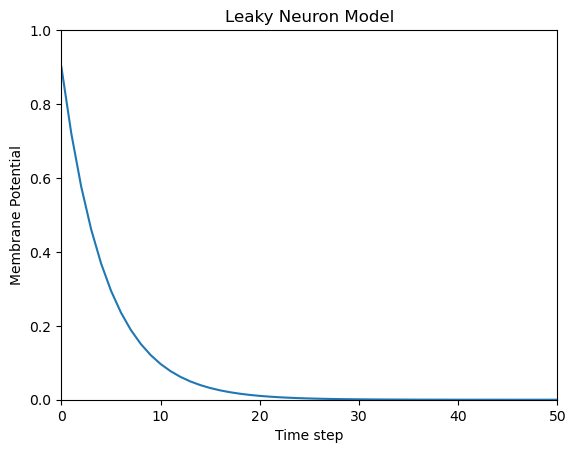

In [6]:
num_steps = 100
U = 0.9
U_trace = []  # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U)  # solve next step of U

plot_mem(U_trace, "Leaky Neuron Model")

This exponential decay seems to match what we expected! 

# 3 Lapicque's LIF Neuron Model

This similarity between nerve membranes and RC circuits was observed by [Louis Lapicque in 1907](https://core.ac.uk/download/pdf/21172797.pdf). He stimulated the nerve fiber of a frog with a brief electrical pulse, and found that neuron membranes could be approximated as a capacitor with a leakage. We pay homage to his findings by naming the basic LIF neuron model in snnTorch after him. 

Most of the concepts in Lapicque's model carry forward to other LIF neuron models. Now it's time to simulate this neuron using snnTorch.

## 3.1 Lapicque: Without Stimulus

Instantiate Lapicque's neuron using the following line of code. R & C are changed to simpler values, while keeping the previous time constant of $\tau=5\times10^{-3}$s.

In [7]:
time_step = 1e-3
R = 5
C = 1e-3

# leaky integrate and fire neuron, tau=5e-3
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

The neuron model is now stored in `lif1`. To use this neuron: 

**Inputs**
* `spk_in`: each element of $I_{\rm in}$ is sequentially passed as an input (0 for now)
* `mem`: the membrane potential, previously $U[t]$, is also passed as input. Initialize it arbitrarily as $U[0] = 0.9~V$.

**Outputs**
* `spk_out`: output spike $S_{\rm out}[t+\Delta t]$ at the next time step ('1' if there is a spike; '0' if there is no spike)
* `mem`: membrane potential $U_{\rm mem}[t+\Delta t]$ at the next time step

These all need to be of type `torch.Tensor`.


In [8]:
# Initialize membrane, input, and output
mem = torch.ones(1) * 0.9  # U=0.9 at t=0
cur_in = torch.zeros(num_steps, 1)  # I=0 for all t 
spk_out = torch.zeros(1)  # initialize output spikes

These values are only for the initial time step $t=0$. 
To analyze the evolution of `mem` over time, create a list `mem_rec` to record these values at every time step.

In [9]:
# A list to store recordings of membrane potential
mem_rec = [mem]

Now it's time to run a simulation! At each time step, `mem` is updated and stored in `mem_rec`:

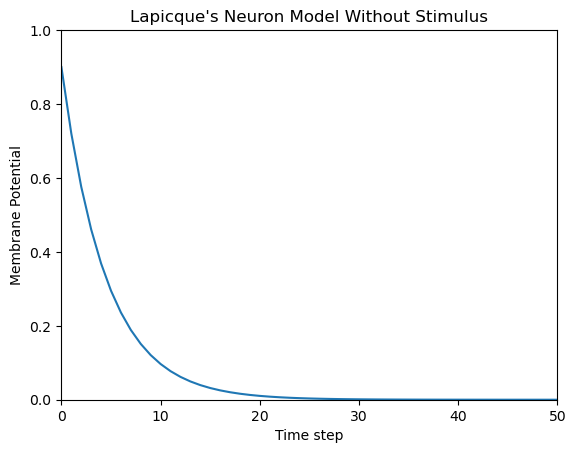

In [10]:
# pass updated value of mem and cur_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

# crunch the list of tensors into one tensor
mem_rec = torch.stack(mem_rec)

plot_mem(mem_rec, "Lapicque's Neuron Model Without Stimulus")

The membrane potential decays over time in the absence of any input stimuli. 

<font color="orange">Notes : </font>

下面的代码块是生成的spk_out - time step的图像，由于模拟的是无输入的情况下，一直处于泄露过程，所以没有脉冲生成

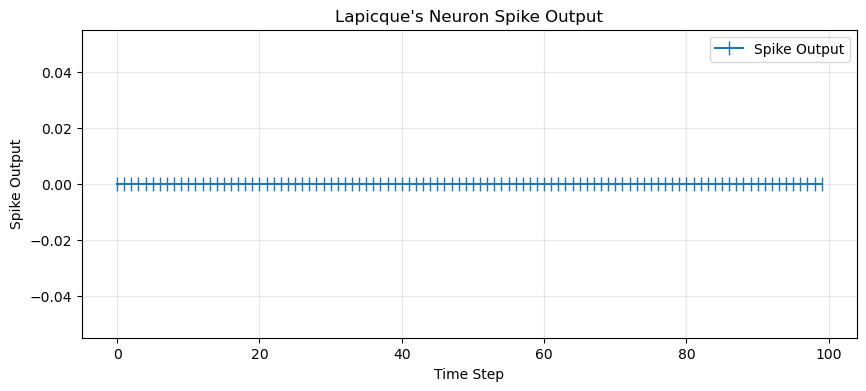

In [14]:
def plot_spike_output(spk_out_list, time_steps, title="Spike Output vs Time Step"):
    """
    Plot spike output over time for a LIF neuron
    
    Parameters:
    spk_out_list (list): List of spike outputs collected over time
    time_steps (int): Number of time steps
    title (str): Title of the plot
    """
    # Convert list of tensors to a single tensor and then to numpy array
    spk_out_array = torch.stack(spk_out_list).numpy()
    
    # Create time points
    time_points = np.arange(time_steps)
    
    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(time_points, spk_out_array, label='Spike Output', marker='|', markersize=10)
    plt.xlabel('Time Step')
    plt.ylabel('Spike Output')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

spk_out_rec = []  # New list to store spike outputs

# Simulation loop
for step in range(num_steps):
    spk_out, mem = lif1(cur_in[step], mem)
    # mem_rec.append(mem)
    spk_out_rec.append(spk_out)  # Store spike output at each step


# Plot the spike output
plot_spike_output(spk_out_rec, num_steps, "Lapicque's Neuron Spike Output")

## 3.2 Lapicque: Step Input

Now apply a step current $I_{\rm in}(t)$ that switches on at $t=t_0$. Given the linear first-order differential equation:

$$ \tau \frac{dU_{\rm mem}}{dt} = -U_{\rm mem} + RI_{\rm in}(t),$$

the general solution is:

$$U_{\rm mem}=I_{\rm in}(t)R + [U_0 - I_{\rm in}(t)R]e^{-\frac{t}{\tau}}$$

If the membrane potential is initialized to $U_{\rm mem}(t=0) = 0 V$, then:

$$U_{\rm mem}(t)=I_{\rm in}(t)R [1 - e^{-\frac{t}{\tau}}]$$

Based on this explicit time-dependent form, we expect $U_{\rm mem}$ to relax exponentially towards $I_{\rm in}R$. Let's visualize what this looks like by triggering a current pulse of $I_{in}=100mA$ at $t_0 = 10ms$.

In [15]:
# Initialize input current pulse
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.1), 0)  # input current turns on at t=10

# Initialize membrane, output and recordings
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes
mem_rec = [mem]

This time, the new values of `cur_in` are passed to the neuron:

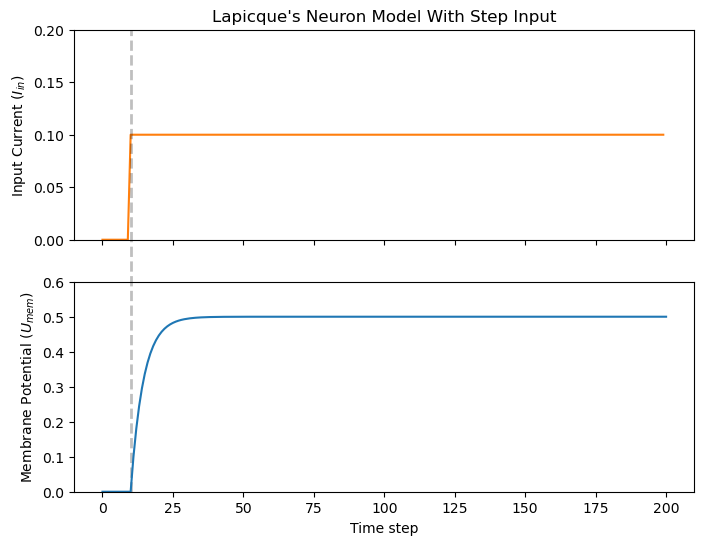

In [16]:
num_steps = 200

# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)

# crunch -list- of tensors into one tensor
mem_rec = torch.stack(mem_rec)

plot_step_current_response(cur_in, mem_rec, 10)

<font color="orange">Notes : </font>

- 图一：输入电流强度
- 图二：膜电压状态

As $t\rightarrow \infty$, the membrane potential $U_{\rm mem}$ exponentially relaxes to $I_{\rm in}R$:

In [17]:
print(f"The calculated value of input pulse [A] x resistance [Ω] is: {cur_in[11]*lif1.R} V")
print(f"The simulated value of steady-state membrane potential is: {mem_rec[200][0]} V")

The calculated value of input pulse [A] x resistance [Ω] is: tensor([0.5000]) V
The simulated value of steady-state membrane potential is: 0.4999999403953552 V


Close enough!

## 3.3 Lapicque: Pulse Input

Now what if the step input was clipped at $t=30ms$?

In [18]:
# Initialize current pulse, membrane and outputs
cur_in1 = torch.cat((torch.zeros(10, 1), torch.ones(20, 1)*(0.1), torch.zeros(170, 1)), 0)  # input turns on at t=10, off at t=30
# 上面这行代码创建了一个包含200个元素的张量 `cur_in1`，其中前10个元素为0，中间20个元素为0.1，最后170个元素为0。具体来说：
# - `torch.zeros(10)` 创建一个包含10个元素且值为0的张量。
# - `torch.ones(20) * (0.1)` 创建一个包含20个元素且值为0.1的张量。
# - `torch.zeros(170)` 创建一个包含170个元素且值为0的张量。
# - `torch.cat(..., 0)` 将上述三个张量沿第一个维度（即行）连接起来，形成一个长度为200的张量。

# 这个张量可以用作输入电流 `cur_in1`，用于模拟神经元在不同时间步的行为。
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec1 = [mem]

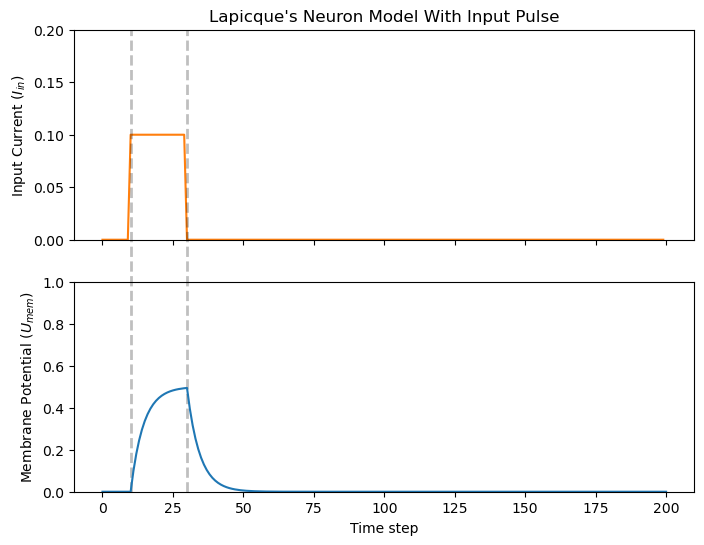

In [19]:
# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in1[step], mem)
  mem_rec1.append(mem)
mem_rec1 = torch.stack(mem_rec1)

plot_current_pulse_response(cur_in1, mem_rec1, "Lapicque's Neuron Model With Input Pulse", 
                            vline1=10, vline2=30)

$U_{\rm mem}$ rises just as it did for the step input, but now it decays with a time constant of $\tau$ as in our first simulation. 

Let's deliver approximately the same amount of charge $Q = I \times t$ to the circuit in half the time. This means the input current amplitude must be increased by a little, and the time window must be decreased.

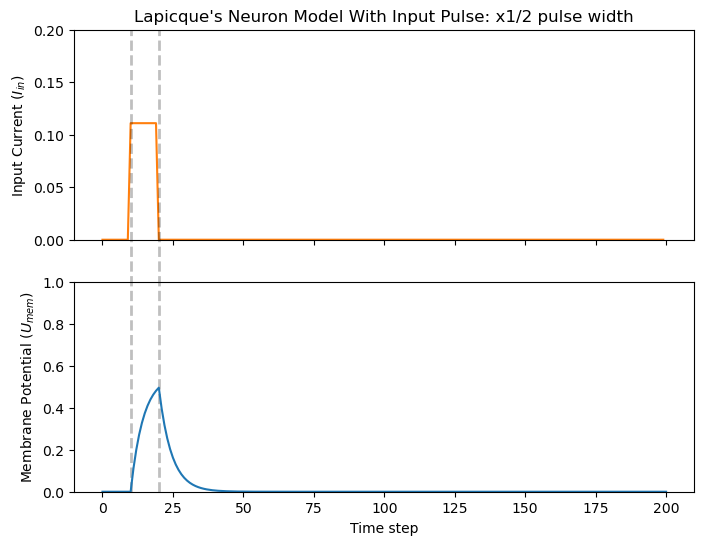

In [20]:
# Increase amplitude of current pulse; half the time.
cur_in2 = torch.cat((torch.zeros(10, 1), torch.ones(10, 1)*0.111, torch.zeros(180, 1)), 0)  # input turns on at t=10, off at t=20
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec2 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in2[step], mem)
  mem_rec2.append(mem)
mem_rec2 = torch.stack(mem_rec2)

plot_current_pulse_response(cur_in2, mem_rec2, "Lapicque's Neuron Model With Input Pulse: x1/2 pulse width",
                            vline1=10, vline2=20)

Let's do that again, but with an even faster input pulse and higher amplitude:

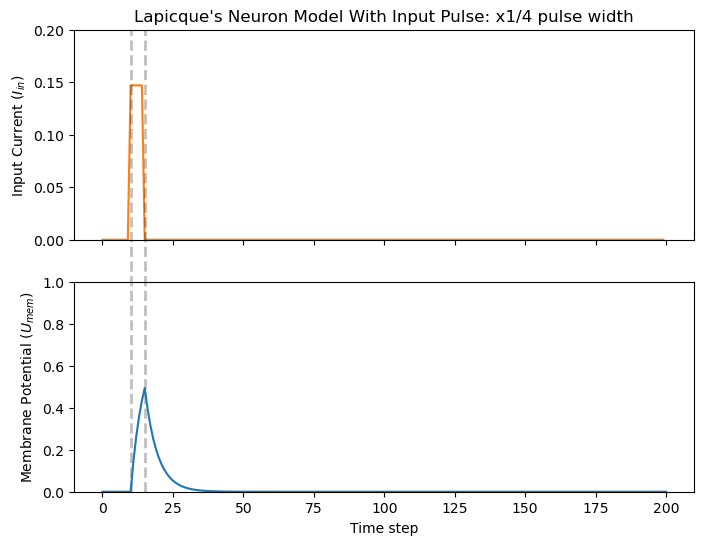

In [21]:
# Increase amplitude of current pulse; quarter the time.
cur_in3 = torch.cat((torch.zeros(10, 1), torch.ones(5, 1)*0.147, torch.zeros(185, 1)), 0)  # input turns on at t=10, off at t=15
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec3 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in3[step], mem)
  mem_rec3.append(mem)
mem_rec3 = torch.stack(mem_rec3)

plot_current_pulse_response(cur_in3, mem_rec3, "Lapicque's Neuron Model With Input Pulse: x1/4 pulse width",
                            vline1=10, vline2=15)# vlines是图中两条垂直于time step轴的虚线

Now compare all three experiments on the same plot:

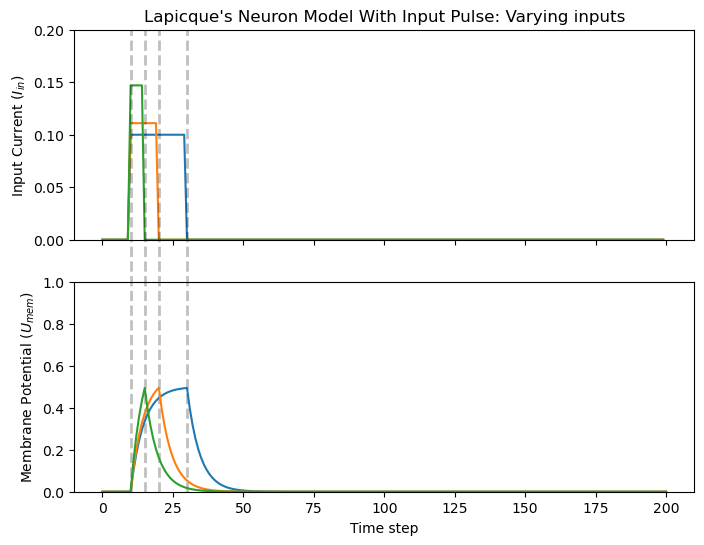

In [22]:
compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, 10, 15, 
              20, 30, "Lapicque's Neuron Model With Input Pulse: Varying inputs")

As the input current pulse amplitude increases, the rise time of the membrane potential speeds up. In the limit of the input current pulse width becoming infinitesimally small, $T_W \rightarrow 0s$, the membrane potential will jump straight up in virtually zero rise time:

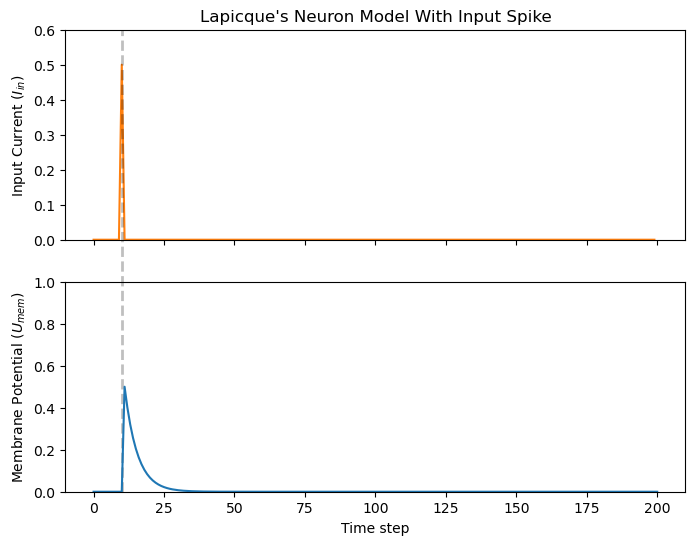

In [23]:
# Current spike input
cur_in4 = torch.cat((torch.zeros(10, 1), torch.ones(1, 1)*0.5, torch.zeros(189, 1)), 0)  # input only on for 1 time step
mem = torch.zeros(1) 
spk_out = torch.zeros(1)
mem_rec4 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in4[step], mem)
  mem_rec4.append(mem)
mem_rec4 = torch.stack(mem_rec4)

plot_current_pulse_response(cur_in4, mem_rec4, "Lapicque's Neuron Model With Input Spike", 
                            vline1=10, ylim_max1=0.6)

The current pulse width is now so short, it effectively looks like a spike. That is to say, charge is delivered in an infinitely short period of time, $I_{\rm in}(t) = Q/t_0$ where $t_0 \rightarrow 0$. More formally:

$$I_{\rm in}(t) = Q \delta (t-t_0),$$

where $\delta (t-t_0)$ is the Dirac-Delta function. Physically, it is impossible to 'instantaneously' deposit charge. But integrating $I_{\rm in}$ gives a result that makes physical sense, as we can obtain the charge delivered:

$$1 = \int^{t_0 + a}_{t_0 - a}\delta(t-t_0)dt$$

$$f(t_0) = \int^{t_0 + a}_{t_0 - a}f(t)\delta(t-t_0)dt$$

Here, $f(t_0) = I_{\rm in}(t_0=10) = 0.5A \implies f(t) = Q = 0.5C$.


Hopefully you have a good feel of how the membrane potential leaks at rest, and integrates the input current. That covers the 'leaky' and 'integrate' part of the neuron. How about the fire? 

<font color='orange'>Notes : </font>

清晰地分离"输入"和"泄露"两个过程：

- 首先是瞬时的电荷输入（δ函数脉冲）
- 然后是连续的泄露过程（RC电路的指数衰减）

这种数学描述反映了真实神经元的工作特点：

- 突触输入是离散的、脉冲式的
- 而膜电位的变化是连续的、平滑的
- 泄露过程始终存在，这确保了神经元能够"遗忘"旧的输入，对新的输入保持敏感

简单类比：想象一个漏水的水桶

- δ函数输入就像往桶里倒入一杯水（瞬时的、量化的输入）
- 桶底的小孔导致水位缓慢下降（持续的泄露过程）
- 只有当注入水的速度足够快、量足够大，水位才能升到特定高度（达到发放阈值）

## 3.4 Lapicque: Firing

So far, we have only seen how a neuron will react to spikes at the input. For a neuron to generate and emit its own spikes at the output, the passive membrane model must be combined with a threshold.

If the membrane potential exceeds this threshold, then a voltage spike will be generated, external to the passive membrane model. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_spiking.png?raw=true' width="450">
</center>

Modify the `leaky_integrate_neuron` function from before to add a spike response.

In [24]:
# R=5.1, C=5e-3 for illustrative purposes
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = mem + (time_step/tau_mem)*(-mem + cur*R)
  return mem, spk

Set `threshold=1`, and apply a step current to get this neuron spiking.

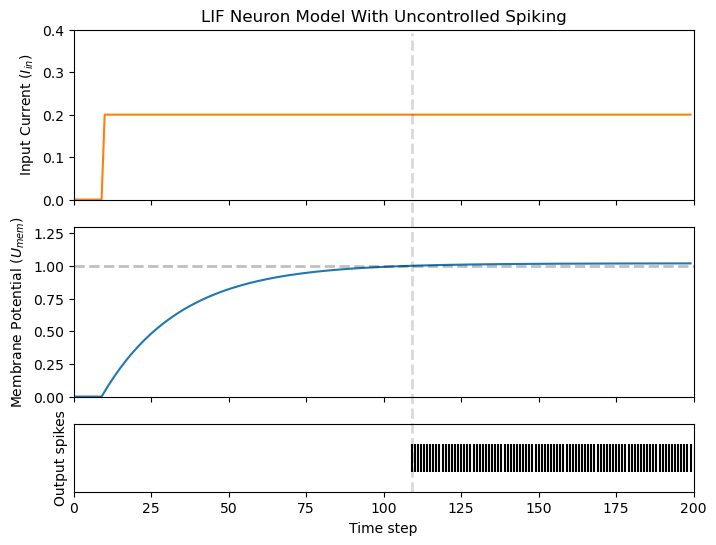

In [25]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3, 
                 title="LIF Neuron Model With Uncontrolled Spiking")

Oops - the output spikes have gone out of control! This is because we forgot to add a reset mechanism. In reality, each time a neuron fires, the membrane potential hyperpolarizes back to its resting potential.

Implementing this reset mechanism into our neuron:

In [26]:
# LIF w/Reset mechanism
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold)
  mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold  # every time spk=1, subtract the threhsold
  return mem, spk

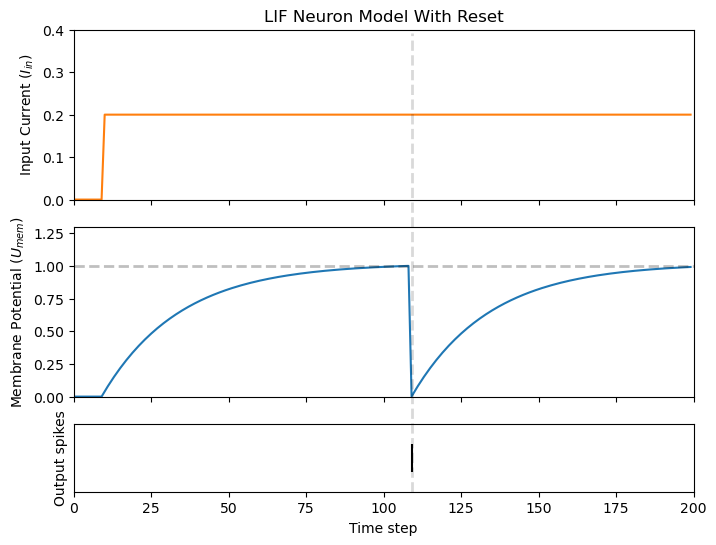

In [27]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3, 
                 title="LIF Neuron Model With Reset")

Bam. We now have a functional leaky integrate-and-fire neuron model! 

Note that if $I_{\rm in}=0.2 A$ and $R<5 \Omega$, then $I\times R < 1 V$. If `threshold=1`, then no spiking would occur. Feel free to go back up, change the values, and test it out.

As before, all of that code is condensed by calling the built-in Lapicque neuron model from snnTorch:

In [52]:
# Create the same neuron as before using snnTorch
lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3)

print(f"Membrane potential time constant: {lif2.R * lif2.C:.3f}s")

Membrane potential time constant: 0.025s


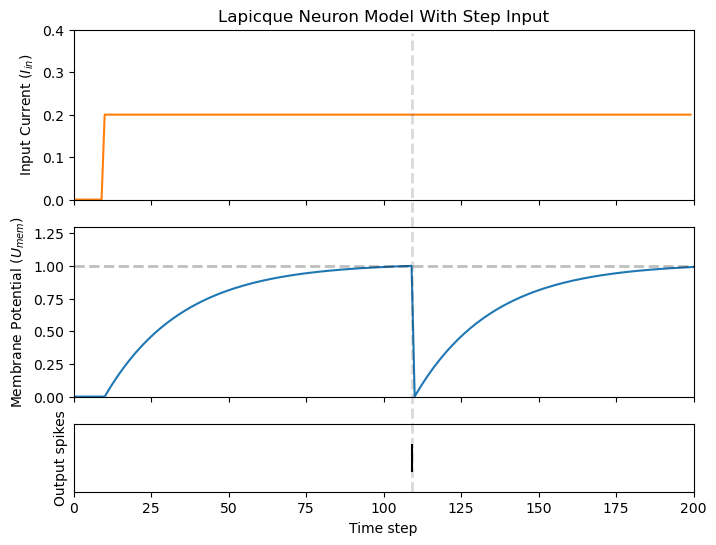

In [53]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.2), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]

# Simulation run across 100 time steps.
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3, 
                 title="Lapicque Neuron Model With Step Input")

The membrane potential exponentially rises and then hits the threshold, at which point it resets. We can roughly see this occurs between $105ms < t_{\rm spk} < 115ms$. As a matter of curiousity, let's see what the spike recording actually consists of:

In [30]:
print(spk_rec[105:115].view(-1))

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


The absence of a spike is represented by $S_{\rm out}=0$, and the occurrence of a spike is $S_{\rm out}=1$. Here, the spike occurs at $S_{\rm out}[t=109]=1$. If you are wondering why each of these entries is stored as a tensor, it is because in future tutorials we will simulate large scale neural networks. Each entry will contain the spike responses of many neurons, and tensors can be loaded into GPU memory to speed up the training process.

If $I_{\rm in}$ is increased, then the membrane potential approaches the threshold $U_{\rm thr}$ faster:

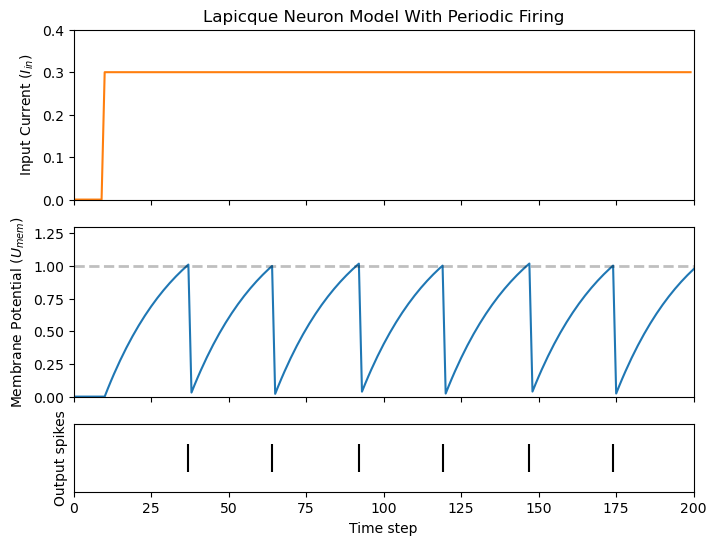

In [31]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.3), 0)  # increased current
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max2=1.3, 
                 title="Lapicque Neuron Model With Periodic Firing")

A similar increase in firing frequency can also be induced by decreasing the threshold. This requires initializing a new neuron model, but the rest of the code block is the exact same as above:

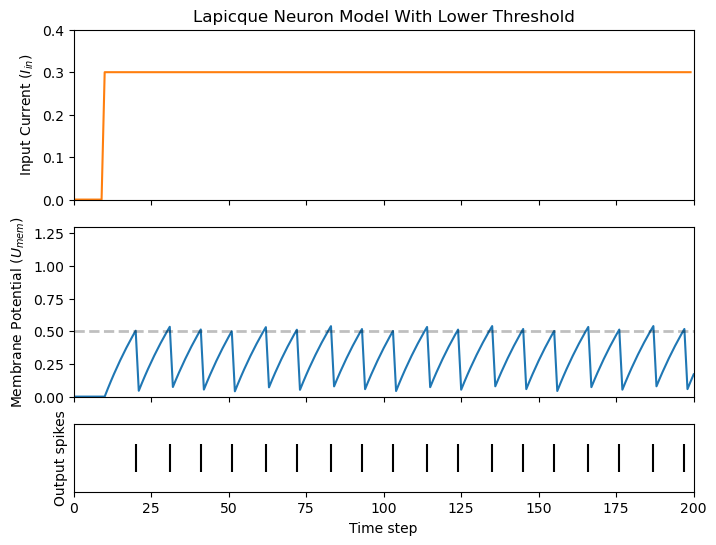

In [32]:
# neuron with halved threshold
lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)

# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.3), 0) 
mem = torch.zeros(1)
spk_out = torch.zeros(1) 
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=0.5, ylim_max2=1.3, 
                 title="Lapicque Neuron Model With Lower Threshold")

That's what happens for a constant current injection. But in both deep neural networks and in the biological brain, most neurons will be connected to other neurons. They are more likely to receive spikes, rather than injections of constant current. 

## 3.5 Lapicque: Spike Inputs

Let's harness some of the skills we learnt in [Tutorial 1](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_1_spikegen.ipynb), and use the `snntorch.spikegen` module to create some randomly generated input spikes.

In [33]:
# Create a 1-D random spike train. Each element has a probability of 40% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps,1)) * 0.40)

Run the following code block to see how many spikes have been generated.

There are 78 total spikes out of 200 time steps.


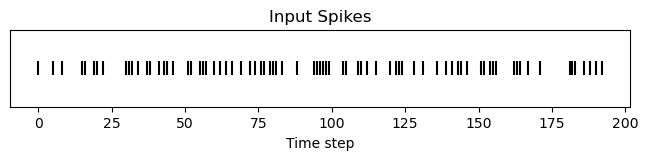

In [40]:
print(f"There are {int(sum(spk_in))} total spikes out of {len(spk_in)} time steps.")

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

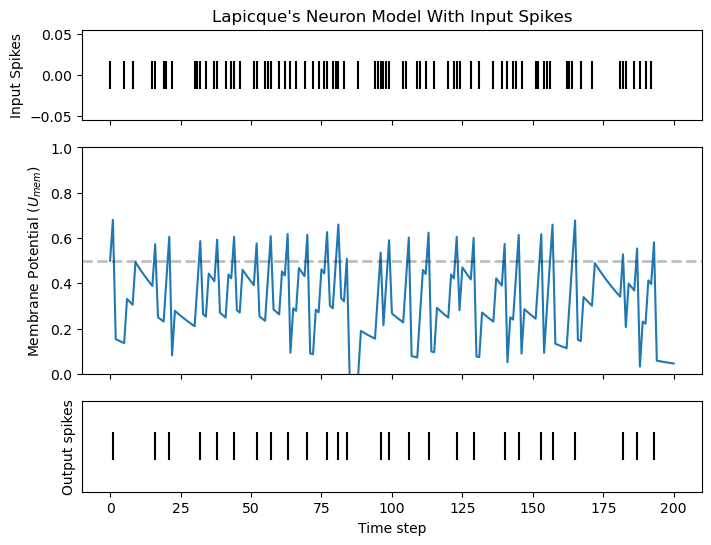

In [43]:
# Initialize inputs and outputs
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(spk_in[step], mem)
  spk_rec.append(spk_out)
  mem_rec.append(mem)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_out, "Lapicque's Neuron Model With Input Spikes")

<font color = 'orange'>Notes : </font>

<font color = 'lightblue'>1. 这里的 `mem = torch.ones(1)*0.5` 和 `threshold=0.5` 实际上是两个不同的概念：</font>

- `threshold=0.5` 是神经元的发放阈值：
    - 这是神经元的一个固定属性
    - 当膜电位超过这个值时，神经元就会发放动作电位
    - 这个值定义了神经元的"决策边界"

- 而 `mem = torch.ones(1)*0.5` 是初始膜电位：
    - 这是神经元在模拟开始时的状态
    - 它可以设置为任何合理的值，不必与阈值相同
    - 这就像给电容器一个初始电压

- 让我用一个生活中的比喻来解释：
    想象一个水桶，我们规定水位到达50cm时水桶就会自动排水（这是阈值threshold=0.5）。而初始水位（mem的初始值）可以是任何值：可以是空的（0cm），可以是半满（25cm），也可以是刚好到阈值（50cm）。初始水位的选择取决于我们想模拟什么样的场景。

- 设置不同的初始膜电位会影响神经元的早期行为：
    - 如果初始值很低，需要更多的输入才能达到发放阈值
    - 如果初始值接近阈值，可能很快就会发放
    - 如果初始值等于阈值，第一个正输入就可能触发发放

<font color = 'lightblue'>2. 从生物神经元的角度来看：</font>

    在真实的生物神经元中，膜电位和阈值有着特定的生理关系：

- 静息膜电位：
    - 通常在-70mV左右
    - 这是神经元在没有任何刺激时的自然状态
    - 由钠钾泵和各种离子通道的共同作用维持
    - 这就相当于我们模型中的初始状态

- 动作电位阈值：
    - 一般在-55mV到-50mV之间
    - 比静息电位高出约15-20mV
    - 这是触发动作电位所需的最小去极化水平
    - 对应我们模型中的threshold参数

- 所以在生物意义上：
    1. 初始膜电位（初始值）应该设置为对应静息膜电位的值
    2. 阈值应该设置为比初始值高出一定幅度的值

- 这种设置的生理学意义：
    1. 保证神经元在静息状态下不会自发放电
    2. 需要足够的输入刺激才能达到发放阈值
    3. 模拟了真实神经元的能量效率原则

- 这就解释了为什么在人工神经元模型中，我们通常：
    - 将初始膜电位设置为较低的值（模拟静息电位）
    - 将阈值设置为明显高于初始值的水平
    - 这样可以更好地模拟生物神经元的工作特性


## 3.6 Lapicque: Reset Mechanisms
We already implemented a reset mechanism from scratch, but let's dive a little deeper. This sharp drop of membrane potential promotes a reduction of spike generation, which supplements part of the theory on how brains are so power efficient. Biologically, this drop of membrane potential is known as 'hyperpolarization'. Following that, it is momentarily more difficult to elicit another spike from the neuron. Here, we use a reset mechanism to model hyperpolarization.

There are two ways to implement the reset mechanism:

1.  *reset by subtraction* (default) $-$ subtract the threshold from the membrane potential each time a spike is generated;
2.  *reset to zero* $-$ force the membrane potential to zero each time a spike is generated.
3.  *no reset* $-$ do nothing, and let the firing go potentially uncontrolled.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_5_reset.png?raw=true' width="450">
</center>

Instantiate another neuron model to demonstrate how to alternate between reset mechanisms. 
By default, snnTorch neuron models use `reset_mechanism = "subtract"`. This can be explicitly overridden by passing the argument `reset_mechanism =  "zero"`.

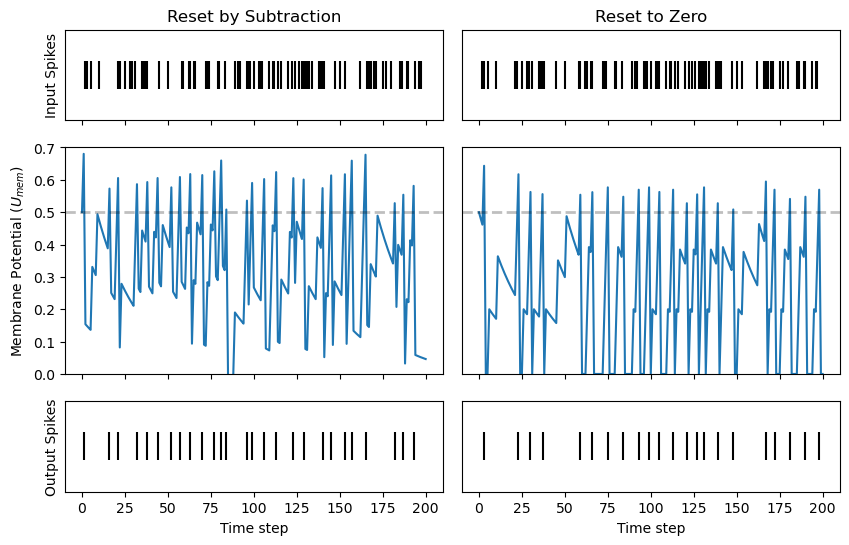

In [44]:
# Neuron with reset_mechanism set to "zero"
lif4 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5, reset_mechanism="zero")

# Initialize inputs and outputs
spk_in = spikegen.rate_conv(torch.ones((num_steps, 1)) * 0.40)
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec0 = [mem]
spk_rec0 = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif4(spk_in[step], mem)
  spk_rec0.append(spk_out)
  mem_rec0.append(mem)

# convert lists to tensors
mem_rec0 = torch.stack(mem_rec0)
spk_rec0 = torch.stack(spk_rec0)

plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0)

Pay close attention to the evolution of the membrane potential, especially in the moments after it reaches the threshold. You may notice that for "Reset to Zero", the membrane potential is forced back to zero after each spike.

So which one is better? Applying `"subtract"` (the default value in `reset_mechanism`) is less lossy, because it does not ignore how much the membrane exceeds the threshold by.

On the other hand, applying a hard reset with `"zero"` promotes sparsity and potentially less power consumption when running on dedicated neuromorphic hardware. Both options are available for you to experiment with. 

That covers the basics of a LIF neuron model!

# Conclusion

In practice, we probably wouldn't use this neuron model to train a neural network. The Lapicque LIF model has added a lot of hyperparameters to tune: $R$, $C$, $\Delta t$, $U_{\rm thr}$, and the choice of reset mechanism. It's all a little bit daunting. So the [next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) will eliminate most of these hyperparameters, and introduce a neuron model that is better suited for large-scale deep learning. 

For reference, the documentation [can be found here](https://snntorch.readthedocs.io/en/latest/snntorch.html).

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.

## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan